In [184]:
%matplotlib inline
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# Import Data

In [185]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
gs=pd.read_csv("gender_submission.csv")

I like to look at the _tail_, rather than the _head_, of a df, since it gives you the number of instances as well as a peak at the data

# Initial analysis

In [186]:
train.tail(2)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [187]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [188]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The train data set has missing values. In particular, the cabin data is particularly sparse.

In [189]:
train.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

So _Age_, _Cabin_, and _Embarked_ features have missing instances. How many rows have missing data?

In [190]:
train.shape[0]-train.dropna().shape[0]

708

We want to model survival or fatality by building a binary classifier. How many people died on the titanic in our train set?

In [203]:
print("Died {} ({:.0f}%)\nSurvived: {} ({:.0f}%)".format(len(train[train["Survived"]==0]),
                                                (len(train[train["Survived"]==0])/len(train))*100,
                                                len(train[train["Survived"]==1]),
                                               (len(train[train["Survived"]==1])/len(train))*100))


Died 549 (62%)
Survived: 342 (38%)


Our train set is biased by 2:1 for deaths vs survival. Lets do a pairwise plot using only rows with full instances with no NAs, and only numeric values

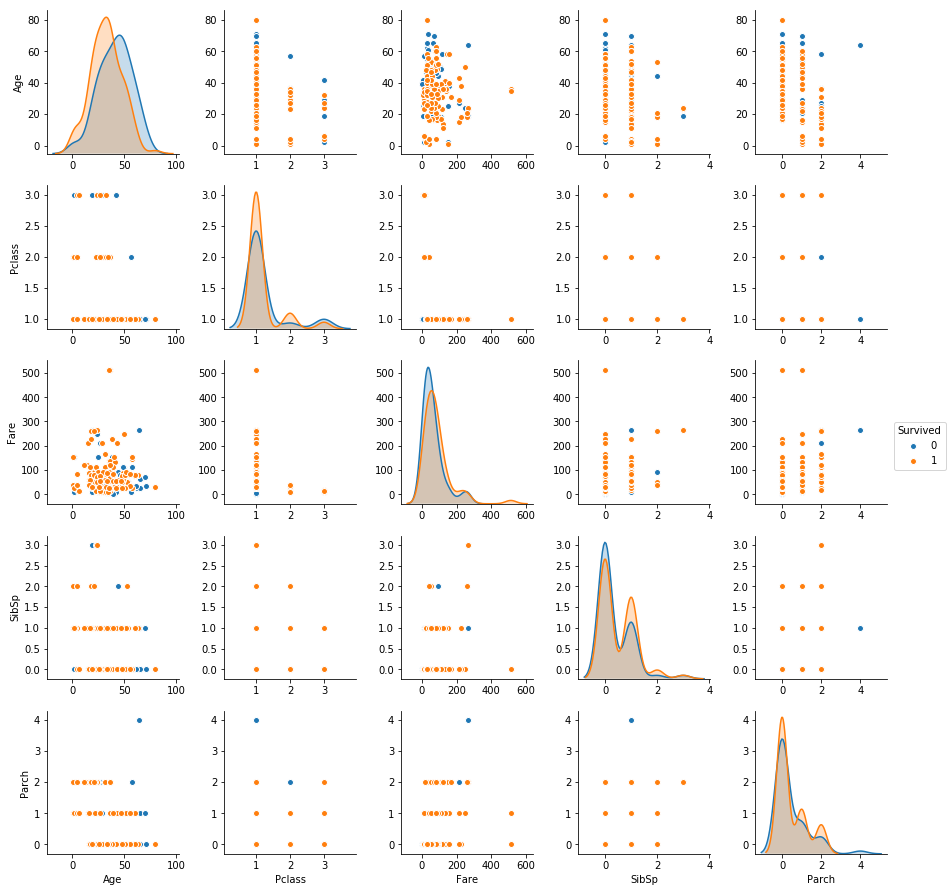

In [204]:
sns.pairplot(train.dropna(),hue="Survived",vars=["Age","Pclass","Fare","SibSp","Parch"],diag_kind="kde",diag_kws=dict(shade=True),)

In [225]:
def plot_by_feat(dataframe,feat1,feat2):
    """Plot two feature 1 against feature 2 of the data frame"""
    positive=dataframe[dataframe[feat1]==1][feat2].value_counts()
    negative=dataframe[dataframe[feat1]==0][feat2].value_counts()
    newdf=pd.DataFrame([positive,negative])
    newdf.index=["positive","negative"]
    newdf.plot(kind='bar',stacked=True,figsize=(4,2),alpha=0.6,width=0.2,fontsize=12)
    

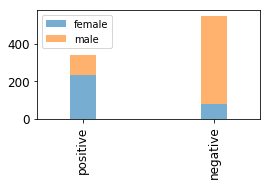

In [226]:
plot_by_feat(train,"Survived","Sex")

It is evident that you are more likely to survive if female.

In [ ]:
fig,ax=pl

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114bda6d8>]], dtype=object)

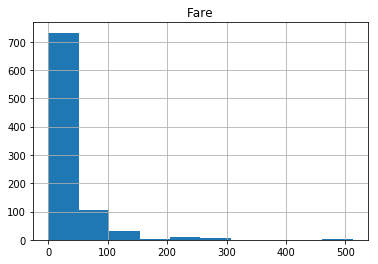

In [206]:
train.hist("Fare")

The fares are far from normally distributed. I may need to play with that later

In order to build a classifier, we are going to have to convert our catagorical features (sex,ticket,embarked) to vectors.

In [11]:
for i in train.select_dtypes(include=['object']).columns:
    print("{}: {} values, {} unique".format(i,len(train[i]),len(train[i].unique())))

Name: 891 values, 891 unique
Sex: 891 values, 2 unique
Ticket: 891 values, 681 unique
Cabin: 891 values, 148 unique
Embarked: 891 values, 4 unique


The name, ticket and cabin variables have many values. For my first model, I will exclude these. I shall only include "Sex" and "Embarked" of the catagorical values in the model. For this I will need to convert them to floating point values

# Conversion of catagorical data

In [12]:
train["Embarked"].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [13]:
train["Sex"].unique()

array(['male', 'female'], dtype=object)

In [14]:
train["Sex"]=train["Sex"].replace(to_replace='male',value=0)
train["Sex"]=train["Sex"].replace(to_replace='female',value=1)
train["Embarked"]=train["Embarked"].replace(to_replace='S',value=0)
train["Embarked"]=train["Embarked"].replace(to_replace='C',value=1)
train["Embarked"]=train["Embarked"].replace(to_replace='Q',value=2)

I am going to test a few different algorithms, using a subset of the data. I expect these to be underfitted, since I have done litte feature engineering up to this point. Iniitally, I will test a few classifiers using _scikitlearn_ to get a baseline accuracy. I will then do some feature engineering to improve the models. 

# Baseline models

In [27]:
features=["Survived","Pclass","Sex","Age","SibSp","Parch","Fare","Embarked"]

In [16]:
#X=train.dropna()[features]
#y=train.dropna()["Survived"]
#print(len(X),len(y))
#y.mean()

In [35]:
X=train[features].dropna().drop("Survived",axis=1)
y=train[features].dropna()["Survived"]
print(len(X),len(y))
print(y.mean())

712 712
0.404494382022


So 40% of our input data for the first model have value==1 (ie, they survived). This is fair reflection of the original set, which has a 38% survival rate. For the current train set, if we predict 1 for every instance, we would be correct 40% of the time.

I am going to further split our train data set into a train and test set, so we can test our model properly, since the _test_ set provided by Kaggle does not have an answer we can check so we cannot validate our model against it

In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(len(y_train))
print(len(y_test))
print(y_train.mean())
print(y_test.mean())

534
178
0.397003745318
0.426966292135


In [109]:
scores={}

### Gaussian Naive Bayes

The first method I will trial is Gaussian Naive Bayes

In [110]:
from sklearn.naive_bayes import GaussianNB

In [111]:
gnb = GaussianNB()
gnb=gnb.fit(X_train,y_train)
gnb.score(X_train,y_train)
print(gnb.score(X_train,y_train))

0.784644194757


So GNB is accurate on 78.5% of the training data. What about the test set?

In [112]:
print("GNB accurately predicts {:.2f}% of the test set".format(gnb.score(X_test,y_test)*100))
scores["GNB"]=gnb.score(X_test,y_test)*100

GNB accurately predicts 78.09% of the test set


In [113]:
gnb_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total {} points : {}".format(X_test.shape[0],(y_test != gnb_pred).sum()))

Number of mislabeled points out of a total 178 points : 39


In [41]:
from sklearn.metrics import confusion_matrix

In [114]:
tn, fp, fn, tp = confusion_matrix(y_test,gnb_pred).ravel()
(tn, fp, fn, tp)

(83, 19, 20, 56)

In [115]:
print("Correct deaths: {}\nIncorrect Survival: {}\nIncorrect Death: {}\nCorrect Surivival: {}".format(tn,fp,fn,tp))

Correct deaths: 83
Incorrect Survival: 19
Incorrect Death: 20
Correct Surivival: 56


### Logistic Regression

In [132]:
from sklearn.linear_model import LogisticRegression 

In [133]:
lrmodel=LogisticRegression()
lrmodel=lrmodel.fit(X_train,y_train)
lrmodel.score(X_train,y_train)


0.797752808988764

In [134]:
lrmodel.score(X_test,y_test)
scores["LR"]=lrmodel.score(X_test,y_test)*100

In [135]:
lr_pred = lrmodel.fit(X_train, y_train).predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
(tn, fp, fn, tp)

(84, 18, 22, 54)

In [136]:
print("Correct deaths: {}\nIncorrect Survival: {}\nIncorrect Death: {}\nCorrect Surivival: {}".format(tn,fp,fn,tp))

Correct deaths: 84
Incorrect Survival: 18
Incorrect Death: 22
Correct Surivival: 54


### Decision Tree

In [137]:
from sklearn.tree import DecisionTreeClassifier

In [138]:
dt=DecisionTreeClassifier()
dt=dt.fit(X_train,y_train)
dt.score(X_train,y_train)


0.99250936329588013

In [139]:
dt.score(X_test,y_test)
scores["DT"]=dt.score(X_test,y_test)*100

In [140]:
dt_pred = treemodel.fit(X_train, y_train).predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test,dt_pred).ravel()
(tn, fp, fn, tp)

(84, 18, 21, 55)

In [141]:
print("Correct deaths: {}\nIncorrect Survival: {}\nIncorrect Death: {}\nCorrect Surivival: {}".format(tn,fp,fn,tp))

Correct deaths: 84
Incorrect Survival: 18
Incorrect Death: 21
Correct Surivival: 55


### Gradient Boosting

Lets see if gradient boosting improves upon the lone decision tree

In [142]:
from  sklearn.ensemble import GradientBoostingClassifier

In [143]:
gb=GradientBoostingClassifier()
gb=gb.fit(X_train,y_train)
gb.score(X_train,y_train)

0.9157303370786517

In [144]:
gb.score(X_test,y_test)
scores["gb"]=gb.score(X_test,y_test)*100

# Summary of baseline models

In [146]:
scores

{'DT': 79.775280898876403,
 'GNB': 78.089887640449433,
 'LR': 78.651685393258433,
 'gb': 82.022471910112358}

# Engineering

In [187]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null float64
dtypes: float64(3), int64(6), object(3)
memory usage: 83.6+ KB


In [147]:
print("{} in the set, {} features in the training set, {} in the test set. {} features excluded".format(train.shape[0],y_train.shape[0],y_test.shape[0],(train.shape[0]-(y_train.shape[0]+y_test.shape[0]))))

891 in the set, 534 features in the training set, 178 in the test set. 179 features excluded


The first feature I want to work on is whether someone is travelling alone or not. It seems to me that a child's survival chance will be improved if they are travelling with an adult, and vice versa, since we know history (and the movie _Titanic_ ;)) that women and children were evacuated on life boats.

In [161]:
train["Solo"]=train["Parch"] + train["SibSp"]

In [162]:
train['Solo'].loc[train['Solo'] > 0] = 1
train['Solo'].loc[train['Solo'] == 0] = 0


/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [181]:
train["Fare"].range()

AttributeError: 'Series' object has no attribute 'range'